In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [2]:
applied_current = 10 #A/m2

w_S = 0.7 #Mass Fraction Sulfur 
mg_S_cm2 = 10 #Areal Mass Loading Sulfur (mg/cm2)

rho_carbon_bulk = 120 #Typical of high porosity Ketjen black 120

#Cathode Effective Electronic Conductivity
sigma_C_eff = 10 #S/m

#x-discretization
nodes = 50

R = 8.324 #J/mol.K
F = 96485 #C/mol
T = 298 #K

#Species Diffusivity (m2/s) [Li^+, S8, S8^2-, S6^2-, S4^2-, S2^2-, S^2-, A^-]
D_i = np.array([1e-10, 1e-9, 6e-10, 6e-10, 1e-10, 1e-10, 1e-10, 4e-10])

#Material Density (kg/m3)
rho_carbon_true = 2000 


#Porosity of carbon support
eps_void_carbon = 1 - rho_carbon_bulk/rho_carbon_true

#Initial Cathode Dry Composition
m_S = mg_S_cm2/10**6*100**2 #Areal sulfur mass loading (kg/m2)
#Mass Fraction [S8, C]
w_i = np.array([w_S, 1 - w_S])
#Molar mass (kg/mol)
M_i = np.array([0.25648, 0.012011])
#Moles at 1kg basis (mol)
n_i_dry = w_i/M_i
#Molar volumes (m3/mol) 
V_S_n = 1.239e-4
V_C_n_bulk = M_i[1]/rho_carbon_bulk
V_C_n_true = M_i[1]/rho_carbon_true
#Volumes at 1 kg basis (m3)
V_S = V_S_n*n_i_dry[0]
V_C_bulk = V_C_n_bulk*n_i_dry[1]
V_C_true = V_C_n_true*n_i_dry[1]
V_void_C = V_C_bulk*eps_void_carbon
V_void_cat = V_void_C - V_S

eps_S_init = V_S/V_C_bulk #Approximate. Valid until ~95% Sulfur loading.

#Initial Liquid Porosity
eps_elyte_sep_init = 0.39 #separator
eps_elyte_cat_init = V_void_cat/V_C_bulk #cathode (Assuming negligible sulfur contribution to cathode volume)

#Bruggeman Coefficients/Tortuosity
b_sep = -0.5
b_cat = -0.5
tau_elyte_sep_init = eps_elyte_sep_init**b_sep
tau_elyte_cat_init = eps_elyte_cat_init**b_cat

#Initial Concentrations (mol/m3) [Li^+, S8, S8^2-, S6^2-, S4^2-, S2^2-, S^2-, A^-]
C_i = np.array([1001.0440010474534, 19.0, 0.178, 0.324, 0.020, 5.229e-7, 8.267e-10, 1000.0])

#Species charge [Li^+, S8, S8^2-, S6^2-, S4^2-, S2^2-, S^2-, A^-]
z_i = np.array([1, 0, -2, -2, -2, -2, -2, -1])

#Butler-Volmer Parameters
i_o_i = np.array([0.394, 1.972, 0.019, 0.019, 1.97e-4, 1.97e-4])
alpha = 0.5
n_elec = 1
#Stoichiometric coefficients, s_i_j of species i in reaction j
s_i_j = np.array([[-1,0,0,0,0,0,0,0],
                 [0, -1/2,1/2,0,0,0,0,0],
                 [0,0,-3/2,2,0,0,0,0],
                 [0,0,0,-1,3/2,0,0,0],
                 [0,0,0,0,-1/2,1,0,0],
                 [0,0,0,0,0,-1/2,1,0]])
#Half-Cell Potentials
U_half = np.array([0.0, 2.39, 2.37, 2.24, 2.04, 2.01]) #V (vs Li/Li+)
U_half_ref = np.zeros(6) 
for j in range(6):
    U_half_ref[j] = U_half[j] - R*T/n_elec/F*np.sum(s_i_j[j]*np.log(C_i/1000))

#Initial Cathode Surface Area
a_specific_C = 1270. #Carbon specific surface area (m2/kg)
a = a_specific_C*rho_carbon_bulk*(eps_elyte_cat_init/eps_void_carbon)**1.5 #Cathode volumetric surface (m2/m3)


#Cathode Thickness (m)
l_cat = V_S_n/M_i[0]*m_S/eps_S_init

#Separator Thickness (m)
l_sep = 25e-6

#Cell Thickness (m)
l_cell = l_cat + l_sep

#Step size (m)
dx = 5e-06

#x-discretization
x = np.linspace(0, l_cell, nodes)
dx = l_cell/nodes

sep_cat_node = int(round(l_sep/dx)) + 1



In [3]:
#Initialize electrolyte porosity array
eps_elyte = np.zeros(len(x))
D_i_eff = np.zeros((8, len(x)))

#Populate initial conditions
for j in range(sep_cat_node+1):
    eps_elyte[j] = eps_elyte_sep_init
    D_i_eff[:,j] = D_i*eps_elyte[j]/tau_elyte_sep_init
for j in range(sep_cat_node+1,nodes):
    eps_elyte[j] = eps_elyte_cat_init
    D_i_eff[:,j] = D_i*eps_elyte[j]/tau_elyte_cat_init
   

In [4]:
#Function that accepts Butler-Volmer parameters for lithium stripping and outputs faradaic current - minus applied current
#Liquid potential will be varied to set output to zero
def BV_an(phi_elyte_0, U_half_ref, i_o_Li, C_Li, C_Li_ref, nu_Li, alpha, F, R, T):
    eta = 0 - phi_elyte_0 - U_half_ref
    n = i_o_Li*((C_Li/C_Li_ref)**nu_Li*np.exp(alpha*F*eta/R/T) - ((C_Li/C_Li_ref)**(-nu_Li))*np.exp(-alpha*F*eta/R/T)) \
    - applied_current
    return n

#Solves for the electrolyte potential at x = 0 for given concentration, applied current
phi_elyte_0 = fsolve(BV_an, -0.1, args = (U_half_ref[0], i_o_i[0], C_i[0], C_i[0], s_i_j[0,0], alpha, F, R, T))

In [5]:
#Function that accepts Butler-Volmer parameters for cathode reactions and outputs net faradaic current
#Solid potential will be varied to set output to zero
def BV_cat(phi_cat_ref, i_o_i, C_i, C_i_l_ref, s_i_j, alpha, F, R, T, sep_cat_node, phi_elyte, U_half_ref):
    eta_j = phi_cat_ref - phi_elyte - U_half_ref
    i_j_ref = i_o_i*((np.prod((C_i/C_i_l_ref)**s_i_j))*np.exp(alpha*F*eta_j/R/T) - \
            (np.prod((C_i/C_i_l_ref)**-s_i_j))*np.exp(-alpha*F*eta_j/R/T))
    i_sum = np.sum(i_j_ref[1:])
    return i_sum

In [6]:
#Initialize arrays for solid potential
phi_s = np.zeros_like(x)

#Populate phi_s with some initial guesses
phi_cat_ref = fsolve(BV_cat, 2.5, args = (i_o_i, C_i, C_i, s_i_j, alpha, F, R, T, sep_cat_node, phi_elyte_0, U_half_ref))
for j in range(sep_cat_node+1,nodes):
    phi_s[j] = phi_cat_ref - (j-sep_cat_node-1)*0.0001

#Initialize first and second derivatives of phi_s
dphi_s_dx = np.zeros_like(x)
ddphi_s_dxx = np.zeros_like(x)

In [7]:
#Initialize arrays for liquid potential and populate with initial guesses
phi_e = phi_elyte_0*np.linspace(1,0.9,len(x))

#Initialize first and second derivatives of phi_e
dphi_e_dx = np.zeros_like(x)
ddphi_e_dxx = np.zeros_like(x)

In [8]:
#Initializae arrays for current and current derivatives
i_e = np.zeros_like(x)
i_s = np.zeros_like(x)
di_e_dx = np.zeros_like(x)
di_s_dx = np.zeros_like(x)

Text(0, 0.5, 'Potential (V vs Li/Li$^+$)')

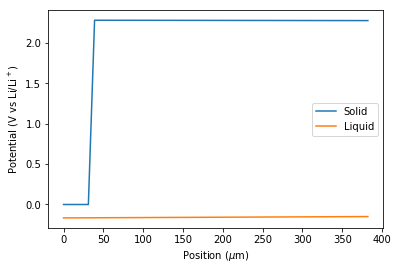

In [9]:
#Plot the initial guesses for phi
plt.plot(x*1e6,phi_s, label = 'Solid')
plt.plot(x*1e6,phi_e, label = 'Liquid')
plt.legend()
plt.xlabel('Position ($\mu$m)')
plt.ylabel('Potential (V vs Li/Li$^+$)')

In [10]:
#The following section loops through position j several times to converge on a solution for phi_s and phi_e
for iter in range(10000): #Iteration counter. A while loop with some sort of residual value would be better, but \
                            #probably not worth it considering the results are questionable. \
                            #For some reason the solution converges very slowly so many iterations are needed.
    #Start at the anode-separator boundary
    j = 0
    phi_s[j] = 0 #Lithium is the reference for potential
    dphi_s_dx[j] = 0 #Zero potential drop due to zero electronic current
    ddphi_s_dxx[j] = 0 #Constant potential drop
    phi_e[j] = phi_elyte_0 #Liquid potential calculated from Butler-Volmer kinetics
    dphi_e_dx[j] = -applied_current*R*T/(eps_elyte[j]*z_i[0]*D_i_eff[0,j]*C_i[0]*F**2) \
                                        #Current carried only by lithium ion molar flux
    ddphi_e_dxx[j] = 0 #Constant liuid phase current
    
    i_e[j] = applied_current
    i_s[j] = 0
    
    #Progress through the separator layer
    for j in range(1,sep_cat_node+1):
        dphi_s_dx[j] = dphi_s_dx[j-1] #Constant derivative in separator
        ddphi_s_dxx[j] = ddphi_s_dxx[j-1] #Constant derivative in separator
        phi_s[j] = phi_s[j-1] + dphi_s_dx[j]*dx #Backwards finite difference calculation
        dphi_e_dx[j] = dphi_e_dx[j-1] #Constant derivative in separator
        ddphi_e_dxx[j] = ddphi_e_dxx[j-1] #Constant derivative in separator
        phi_e[j] = phi_e[j-1] + dphi_e_dx[j]*dx #backwards finite difference calculation
        
        i_e[j] = applied_current #No faradaic reactions: di_e/dx = 0
        i_s[j] = 0 #No faradaic reactions: di_s/dx = -di_e/dx = 0
        
    #Calculate for the first node in the cathode layer "sep_cat_node+1"
    j = sep_cat_node + 1
    ddphi_e_dxx[j] = 0 #Ionic flux is equal across the separator-cathode interface
    phi_e[j] = (phi_e[j+1] + phi_e[j-1] - ddphi_e_dxx[j]*dx**2)/2 #Central finite difference to link two solutions
    dphi_e_dx[j] = 0 #No change in electrolyte current in first node of cathode
    phi_s[j] = fsolve(BV_cat, 2.5, args = (i_o_i, C_i, C_i, s_i_j, alpha, F, R, T, sep_cat_node, phi_elyte_0, U_half_ref))
    dphi_s_dx[j] = 0 #No solid current in first node of cathode
    ddphi_s_dxx[j] = 0 #No faradaic current in first node of cathode
    
    i_e[j] = applied_current #No faradaic current in first node of cathode
    i_s[j] = 0 #No faradaic current in first node of cathode
    
    #Progress through the cathode layer
    for j in range(sep_cat_node+2,nodes-1):
        i_j_sum = BV_cat(phi_s[j], i_o_i, C_i, C_i, s_i_j, alpha, F, R, T, sep_cat_node, phi_e[j], U_half_ref) \
                                                #Calculate the net faradaic current in the node
        ddphi_s_dxx[j] = a/sigma_C_eff*i_j_sum #Ohm's law for potential drop in a solid
        phi_s[j] = (phi_s[j+1] + phi_s[j-1] - ddphi_s_dxx[j]*dx**2)/2 #Center finite difference calculation
        dphi_s_dx[j] = (phi_s[j+1] - phi_s[j-1])/dx #Center finite difference calculation
        ddphi_e_dxx[j] = -a*i_j_sum/(np.sum(z_i**2*F**2*D_i_eff[:,j]*C_i/(R*T))) \
                        #Relating second derivative of phi_e with the first derivative of the flux via Nernst-Plank eqn
        phi_e[j] = (phi_e[j+1] + phi_e[j-1] - ddphi_e_dxx[j]*dx**2)/2 #Center finite difference calculation
        dphi_e_dx[j] = (phi_e[j+1] - phi_e[j-1])/dx #Center finite difference calculation
        
        di_e_dx[j] = a*i_j_sum
        i_e[j] = i_e[j-1] + di_e_dx[j]*dx
        
        di_s_dx[j] = -di_e_dx[j]
        i_s[j] = i_s[j-1] + di_s_dx[j]*dx
        
    #Calculate for the final node in the cathode layer "nodes-1"
    j = nodes - 1
    dphi_s_dx[j] = -applied_current/sigma_C_eff #All current carried by solid phase
    ddphi_s_dxx[j] = 0 #Constant derivative
    phi_s[j] = phi_s[j-1] + dphi_s_dx[j]*dx #Backwards finite difference calculation
    dphi_e_dx[j] = 0 #No ionic flux, impermeable current collector
    ddphi_e_dxx[j] = 0 #Constant first derivative
    phi_e[j] = phi_e[j-1] + dphi_e_dx[j]*dx #Backwards finite difference calculation
    
    i_e[j] = 0
    i_s[j] = applied_current
    

Text(0, 0.5, 'Potential (V vs Li/Li$^+$)')

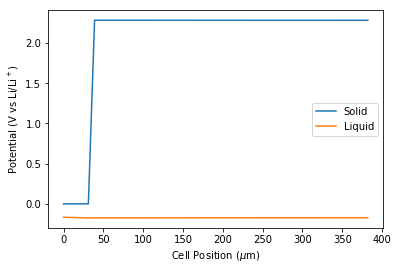

In [11]:
#Plot the full-cell potential solution.
plt.plot(x*1e6, phi_s, label = 'Solid')
plt.plot(x*1e6, phi_e, label = 'Liquid')
plt.legend()
plt.xlabel('Cell Position ($\mu$m)')
plt.ylabel('Potential (V vs Li/Li$^+$)')
#plt.savefig('PotentialSolution-15mg_cm2-1mA_cm2.png')

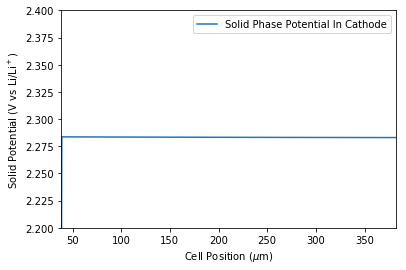

In [12]:
#Plot the solid phase potential in the cathode layer.
plt.plot(x*1e6, phi_s, label = 'Solid Phase Potential In Cathode')
plt.xlim((sep_cat_node+1)*dx*1e6, nodes*dx*1e6)
plt.ylim(2.2,2.4)
plt.xlabel('Cell Position ($\mu$m)')
plt.ylabel('Solid Potential (V vs Li/Li$^+$)')
plt.legend()
#plt.savefig('CathodePhiSol-15mg_cm2-5mA_cm2-loweps_sigma.png')

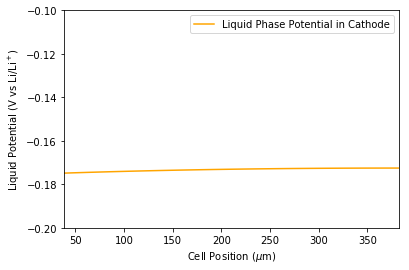

In [13]:
#Plot the liquid phase potential in the cathode layer.
plt.plot(x*1e6, phi_e, 'orange', label = 'Liquid Phase Potential in Cathode')
plt.xlim((sep_cat_node+1)*dx*1e6, nodes*dx*1e6)
plt.ylim(-0.2,-0.1)
plt.xlabel('Cell Position ($\mu$m)')
plt.ylabel('Liquid Potential (V vs Li/Li$^+$)')
plt.legend()
#plt.savefig('CathodePhiLiq-15mg_cm2-5mA_cm2-loweps_sigma.png')

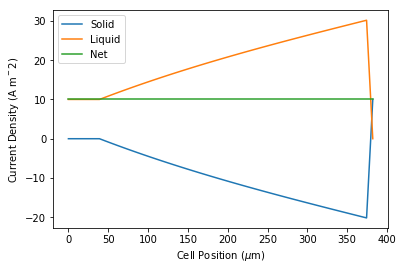

In [14]:
#Calculate net current.
i_tot = i_e + i_s

#Plot current distribution across the cell.
plt.plot(x*1e6, i_s, label = 'Solid')
plt.plot(x*1e6, i_e, label = 'Liquid')
plt.plot(x*1e6, i_tot, label = 'Net')
plt.xlabel('Cell Position ($\mu$m)')
plt.ylabel('Current Density (A m$^-2$)')
plt.legend()
#plt.savefig('Currents-15mg_cm2-1mA_cm2')